In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# import ensemble methods
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from xgboost import XGBClassifier

# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

import warnings

warnings.filterwarnings(
    "ignore", category=DeprecationWarning
)  # to avoid deprecation warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns



In [2]:
df = pd.read_csv('conversion_data_train.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
df.shape

(284580, 6)

Beaucoup de lignes donc on va jouer sur un sample de 10_000

In [4]:
df_sample = df.sample(10000)

In [5]:
df_sample.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.00000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5627,NaN,NaN,4967,NaN,NaN
mean,NaN,30.615700,0.687300,NaN,4.85830,0.032100
std,NaN,8.237123,0.463616,NaN,3.35302,0.176274
min,NaN,17.000000,0.000000,NaN,1.00000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.00000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.00000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.00000,0.000000


In [6]:
df_sample.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [7]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 121468 to 15533
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              10000 non-null  object
 1   age                  10000 non-null  int64 
 2   new_user             10000 non-null  int64 
 3   source               10000 non-null  object
 4   total_pages_visited  10000 non-null  int64 
 5   converted            10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 546.9+ KB


Nous sommes sur un problème de classification:
La target est déjà encodée en 1 ou 0 donc nous n'aurons pas besoin d'un LabelEncoder(). 
On peut potentiellement penser à plusieurs solutions de modèles, à savoir
- Une logistic Regression avec regularisation si overfitting
- Un decision Tree
- Une random Forest
Il faudra penser, en fonction des résultats, au Feature Engineering et Features selection, GridSearchCV.
On peut partir sur un modèle de base avec une Logistic Regression

On remarque qu'il y a des valeurs numériques dans nos Features donc sûrement un standardScaler à faire pour une LR, inuile si on fait une Decision Tree ou RF.
On remarque que nous avons une variable "Country", qu'il faudra Encoder lors de notre preprocessing
On remarque que nous avons une variable 'Source', qu'il faudra encoder lors de notre preprocessing
Pas de valeurs manquantes donc pas d'imputation à faire

## Quelques visualisations avant d'entrainer les modèles

In [8]:
fig = px.bar(df['converted'].value_counts())

fig.show()

In [9]:
for col in df.columns:
    fig = px.bar(df[col].value_counts(), title=col,
                 width=600, height=300)
    fig.show()

### Analyse des variables categorielles sur notre Target

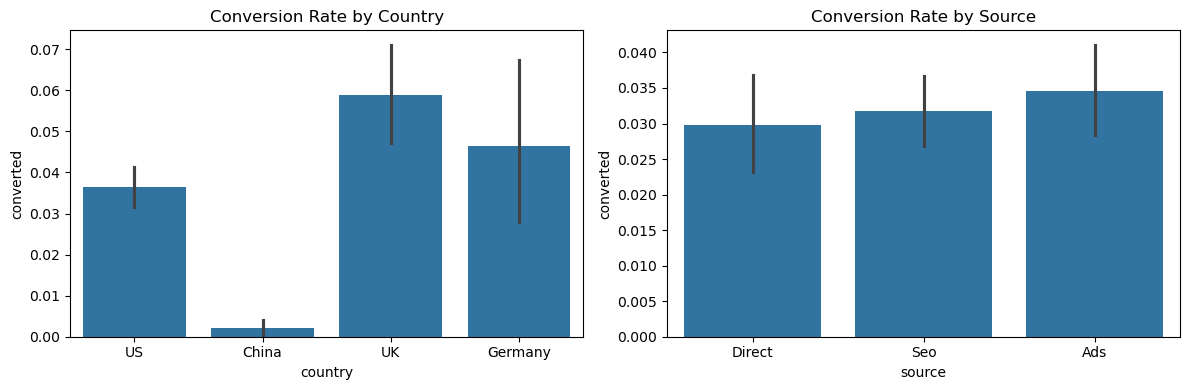

In [10]:
# Create separate barplots for country and source
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.barplot(x='country', y='converted', data=df_sample)
plt.title('Conversion Rate by Country')

plt.subplot(1, 2, 2)
sns.barplot(x='source', y='converted', data=df_sample)
plt.title('Conversion Rate by Source')

plt.tight_layout()
plt.show()

### On peut remarquer que ces deux variables categorielles ont un impact significatif sur l'inscription ou non à la newsletter. Il faudra donc les prendre en compte lors de notre modèle de ML

In [11]:
px.scatter_matrix(df_sample)

On remarque quelques Outliers dans la variable age que l'on va confirmer juste après

In [12]:
display(df_sample['age'].sort_values(ascending=False).head().to_frame())

,age
205047,67
190072,66
244087,64
279061,63
120850,62


In [13]:
# on confirme un outlier avec un age à plus de 100 ans dans notre sample, on va donc garder que les ages < 100
df_sample = df_sample[df_sample['age'] < 100]


01. Baseline model

In [14]:
target_variable = 'converted'

X = df_sample.drop([target_variable], axis=1)
y = df_sample[target_variable]

In [15]:
X.head()

,country,age,new_user,source,total_pages_visited
121468,US,36,1,Direct,7
82250,China,35,0,Seo,6
206930,US,34,1,Ads,8
172583,US,40,1,Direct,4
149470,US,43,1,Ads,4


In [16]:
y.head()

121468    0
82250     0
206930    0
172583    0
149470    0
Name: converted, dtype: int64

In [17]:
numerical_features = ['age', 'total_pages_visited']
categorical_features = ['country', 'new_user', 'source']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
) # pas d'imputer car pas de valeurs manquantes dans les variables numériques

categorical_transformer = OneHotEncoder(
    drop="first"
) # pas d'imputer car pas de valeurs manquantes dans les variables catégorielles

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)



In [20]:
# preprocessing on train set
X_train = preprocessor.fit_transform(X_train)
# preprocessing on test set
X_test = preprocessor.transform(X_test)


In [21]:
baseline = LogisticRegression()

baseline.fit(X_train, y_train)


LogisticRegression()

In [22]:
y_train_pred = baseline.predict(X_train)
y_test_pred = baseline.predict(X_test)

print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Test accuracy: ", accuracy_score(y_test, y_test_pred))

print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

Train accuracy:  0.9855
Test accuracy:  0.99
f1-score on training set :  0.7456140350877193
f1-score on test set :  0.8275862068965517


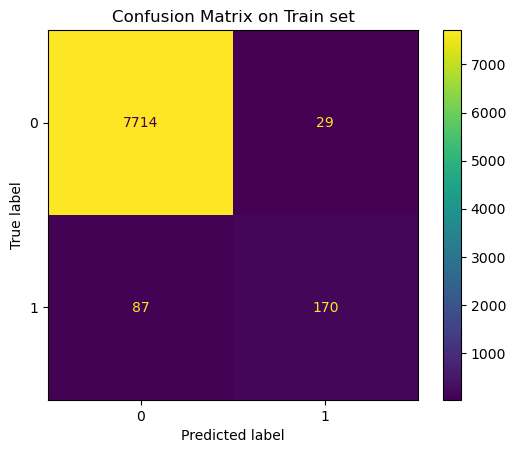

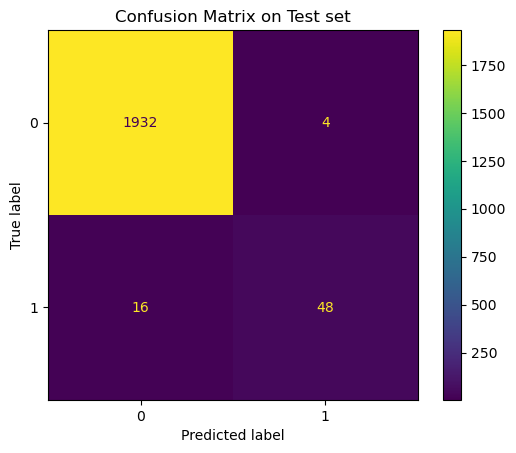

In [23]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    baseline, X_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    baseline, X_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

Analyson ces différentes métrics : 
- Accuracy = taux de précision, ce qui mesure la proportion des prédictions correctes par rapport à l'ensemble des observations
Ici, on a une accuracy de 0.9855 pour le train et 0.99 pour le test.
On peut en tiret deux conclusion, notre modèle performe bien et en plus on overfitt pas

- F1-score = moyenne harmonique entre la précision et le recall. La précision est la proportion de prédictions correctes parmi celles que le modèle a classés comme positive et le recall est la proportion de vrais positifs détectés parmi tous les échantillons positifs réels
Cette métrique est très utile notamment car on a un déséquilibre des classes 'converted', observé plus haut
Nous avons un F1 score de 0.745 sur le train et le 0.827 sur le test, ce qui est pas mal du tout pour une baseline

- Matrice de confusion = qui nous permet de voir comment le modèle classifie ses prédictions par rapport aux vraies classes

### Essayons un bagging classifier sur la logistic regression voir si on peut améliorer la précision

In [24]:
logistic_regression = LogisticRegression(max_iter = 10000)
model = BaggingClassifier(estimator=logistic_regression)

# Grid of values to be tested
params = {
    'estimator__C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 50.0],
    'n_estimators': [4, 5, 8, 10, 20,],
}
print(params)
gridsearch_bag_logreg = GridSearchCV(
    model, param_grid=params, cv=8, verbose = 1) 
  # cv : the number of folds to be used for CV
gridsearch_bag_logreg.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_bag_logreg.best_params_)
print("Best validation accuracy : ", gridsearch_bag_logreg.best_score_)


{'estimator__C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 50.0], 'n_estimators': [4, 5, 8, 10, 20]}
Fitting 8 folds for each of 45 candidates, totalling 360 fits
...Done.
Best hyperparameters :  {'estimator__C': 4.0, 'n_estimators': 5}
Best validation accuracy :  0.9855


In [25]:
# Predictions on training set
y_train_pred = gridsearch_bag_logreg.predict(X_train)

# Predictions on test set
print("Predictions on test set...")
y_test_pred = gridsearch_bag_logreg.predict(X_test)

print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Test accuracy: ", accuracy_score(y_test, y_test_pred))

print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))



Predictions on test set...
Train accuracy:  0.985375
Test accuracy:  0.9895
f1-score on training set :  0.7450980392156863
f1-score on test set :  0.8205128205128205


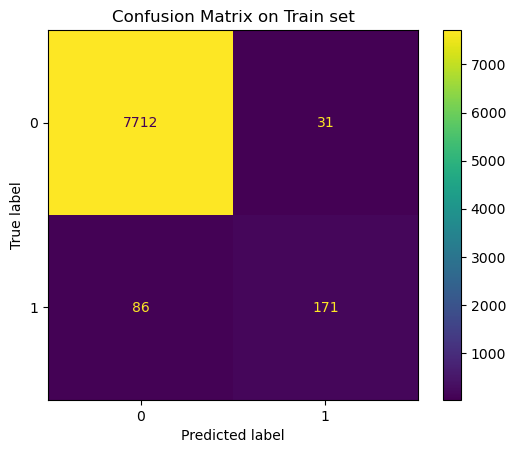

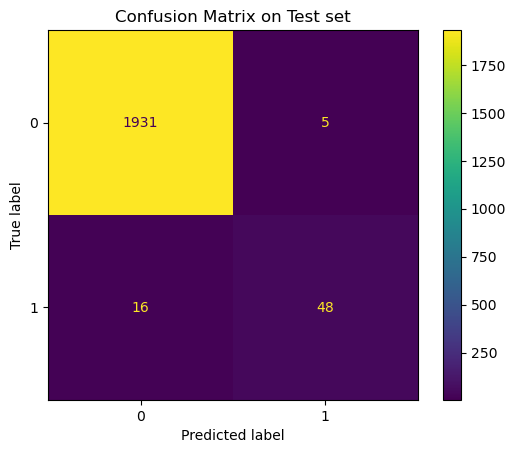

In [26]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    gridsearch_bag_logreg, X_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    gridsearch_bag_logreg, X_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

Nos résultats s'améliorent très très légèrement

### Essayons un XGBOOST

In [27]:
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 3, 4, 5, 6, 8],
    'min_child_weight': [10, 12, 15,20,25,30],
    'n_estimators': [20, 25, 30, 50]
}
print(params)
gridsearch_xgboost = GridSearchCV(xgboost, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearch_xgboost.fit(X_train, y_train)

print("Best hyperparameters : ", gridsearch_xgboost.best_params_)
print("Best validation accuracy : ", gridsearch_xgboost.best_score_)

{'max_depth': [2, 3, 4, 5, 6, 8], 'min_child_weight': [10, 12, 15, 20, 25, 30], 'n_estimators': [20, 25, 30, 50]}
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best hyperparameters :  {'max_depth': 4, 'min_child_weight': 15, 'n_estimators': 50}
Best validation accuracy :  0.9847501245390088


In [28]:
# Predictions on training set
y_train_pred = gridsearch_xgboost.predict(X_train)

# Predictions on test set
print("Predictions on test set...")
y_test_pred = gridsearch_xgboost.predict(X_test)

print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Test accuracy: ", accuracy_score(y_test, y_test_pred))

print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

Predictions on test set...
Train accuracy:  0.986125
Test accuracy:  0.9905
f1-score on training set :  0.7633262260127932
f1-score on test set :  0.8429752066115702


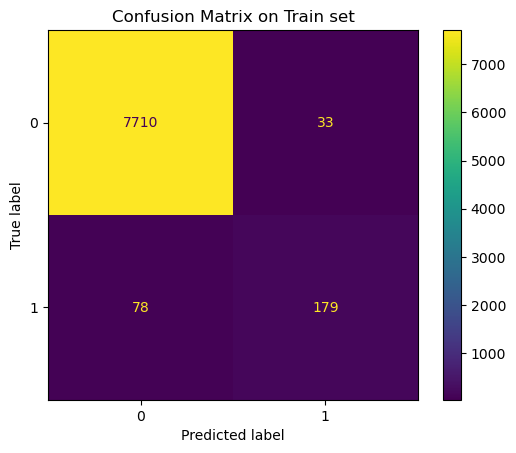

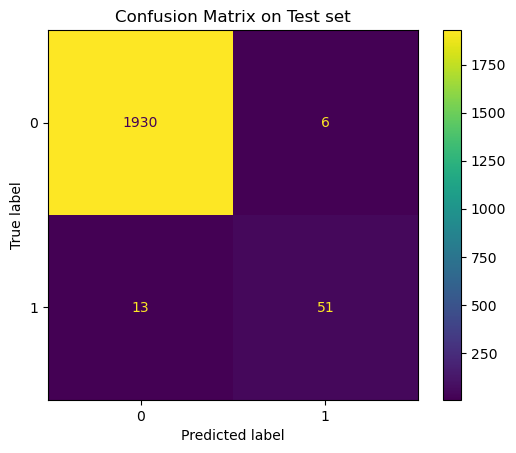

In [29]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    gridsearch_xgboost, X_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    gridsearch_xgboost, X_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

Idem, le XGBoost n'améliore pas de manière nette les résultats

Comme différents modèles n'améliorent pas les résultats et que les meilleurs résultats sont avec notre simple logistic regression, je suppose qu'en faisant un peu de features engineering nous pouvons améliorer nos performances.
Essayons par exemple de rajouter deux colonnes numériques à savoir :
- newuser_x_pages = new_user * total_pages_visited
- age_x_pages = age * total_pages_visited

### Feature Engineering

In [30]:
df_sample['newuser_x_pages'] = df_sample['new_user'] * df_sample['total_pages_visited']
df_sample['age_x_pages'] = df_sample['age'] * df_sample['total_pages_visited']

df_sample.head()

,country,age,new_user,source,total_pages_visited,converted,newuser_x_pages,age_x_pages
121468,US,36,1,Direct,7,0,7,252
82250,China,35,0,Seo,6,0,0,210
206930,US,34,1,Ads,8,0,8,272
172583,US,40,1,Direct,4,0,4,160
149470,US,43,1,Ads,4,0,4,172


In [31]:
target_variable = 'converted'

X = df_sample.drop([target_variable], axis=1)
y = df_sample[target_variable]

numerical_features = ['age', 'total_pages_visited', 'newuser_x_pages', 'age_x_pages']
categorical_features = ['country', 'new_user', 'source']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
) # pas d'imputer car pas de valeurs manquantes dans les variables numériques

categorical_transformer = OneHotEncoder(
    drop="first"
) # pas d'imputer car pas de valeurs manquantes dans les variables catégorielles

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# preprocessing on train set
X_train = preprocessor.fit_transform(X_train)
# preprocessing on test set
X_test = preprocessor.transform(X_test)


LR_with_features_engi = LogisticRegression()

LR_with_features_engi.fit(X_train, y_train)

y_train_pred = LR_with_features_engi.predict(X_train)
y_test_pred = LR_with_features_engi.predict(X_test)

print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Test accuracy: ", accuracy_score(y_test, y_test_pred))

print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))


Train accuracy:  0.9855
Test accuracy:  0.99
f1-score on training set :  0.7456140350877193
f1-score on test set :  0.8275862068965517


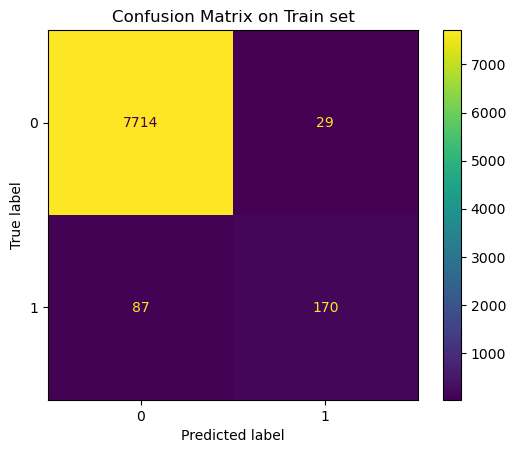

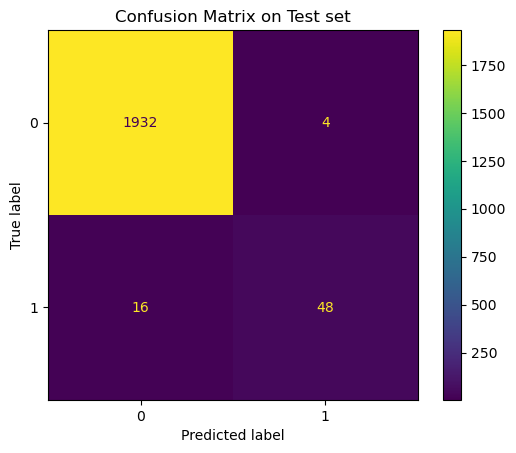

In [35]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    LR_with_features_engi, X_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    LR_with_features_engi, X_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

En conclusion, je pense que la meilleure manière d'améliorer nos résultats c'est de partir sur du feature engineering sur notre baseline. Peut-être en ajoutant quelques features comme des tranches d'ages ou encore des tranches de pages visitées, en ajoutant des catégorielles en plus des numériques

### TEST LORS DU CONVERSION RATE CHALLENGE EN COURS

In [32]:
# X = np.append(X_train, X_test, axis=0)
# y = np.append(y_train, y_test)

# baseline.fit(X, y)

In [33]:
# X_without_labels = pd.read_csv('conversion_data_test.csv')
# X_without_labels = preprocessor.transform(X_without_labels)

# baseline.predict(X_without_labels)

In [34]:
# data = {
#     'converted': baseline.predict(X_without_labels)
# }

# Y_predictions = pd.DataFrame(columns=['converted'],data=data)
# Y_predictions.to_csv('conversion_data_test_predictions_Clement-baseline2.csv', index=False)
